In [1]:
 # To mount Google Drive
from google.colab import drive

# Mount drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import pandas as pd
import numpy as np
from datetime import datetime

import re

df = pd.read_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/baseline_ocsvm_results.csv')
print("Original Size of dataset: {}".format(len(df)))

profiles_df = pd.read_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/consolidated_profiles.csv')
print("Original number of users: {}".format(len(profiles_df)))


filtered_df = df[df['fake_reviews'] == 1]
suspicious_users = list(set(filtered_df['acc_num']))
print("Number of suspicious users: {}".format(len(suspicious_users)))

filtered_df = df[df['acc_num'].isin(suspicious_users)]
print("Size of dataset with fake reviews: {}".format(len(filtered_df)))

Original Size of dataset: 77341
Original number of users: 65930
Number of suspicious users: 7265
Size of dataset with fake reviews: 10296


In [3]:
!pip install --upgrade rgmining-fraud-eagle

     |████████████████████████████████| 61kB 8.4MB/s 
     |████████████████████████████████| 61kB 6.6MB/s 
  Created wheel for rgmining-fraud-eagle: filename=rgmining_fraud_eagle-0.9.7-cp37-none-any.whl size=23771 sha256=3a6cc31e98198505122b14a159f00efd98dcacd017da5933c045243e74b38cbf
  Stored in directory: /root/.cache/pip/wheels/c3/47/6c/9374837be996521760da58b0fb1a963b24cdf6294630ea17fb
  Created wheel for rgmining-common: filename=rgmining_common-0.9.1-cp37-none-any.whl size=17603 sha256=d8d31c305cb92cf2a3b1e643e2cc12c1f63bb7a8cc00baf39d7e0fd9ebe921b3
  Stored in directory: /root/.cache/pip/wheels/20/b1/31/af5575eaf33f211d4988d73db8c13a27fe2c19930fcc0c5757
Successfully built rgmining-fraud-eagle rgmining-common


In [4]:
import fraud_eagle as feagle

# Create a graph with a parameter `epsilon`.
epsilon = 0.1
graph = feagle.ReviewGraph(epsilon)

In [5]:
reviewers = {}
for reviewer in set(filtered_df['acc_num']):
    reviewers[reviewer] = graph.new_reviewer(reviewer)

products = {}
for product in set(filtered_df['asin']):
    products[product] = graph.new_product(product)

for reviewer, product, rating in zip(filtered_df['acc_num'], filtered_df['asin'],filtered_df['cleaned_reviews_ratings']):
    graph.add_review(reviewers[reviewer], products[product], rating)

In [6]:
max_iteration = 10000
for i in range(max_iteration):

   # Run one iteration.
   diff = graph.update()
   print("Iteration {}...Difference={}".format(i + 1, diff))

   if diff < 10**-5: # Set 10^-5 as an acceptable small number.
       print("Difference is significantly small...Stopping Iteration...")
       break

Iteration 1...Difference=0.38888888888889805
Iteration 2...Difference=0.3499999999999974
Iteration 3...Difference=0.13743343572419064
Iteration 4...Difference=0.004475384079504818
Iteration 5...Difference=0.00013081137604042947
Iteration 6...Difference=1.560524664656615e-06
Difference is significantly small...Stopping Iteration...


In [7]:
mean_anomalous_score = np.mean([r.anomalous_score for r in graph.reviewers])
top_users = [r.name for r in graph.reviewers if r.anomalous_score > mean_anomalous_score]
print(top_users)
print(len(top_users))

['AFELRQ2BCTU4SS54IOXSRVS2G5RQ', 'AHGIY5CQZNINXPHNEVKBJADS45LA', 'AFFEY2LYCCORVAF6522ZLXDBAQDQ', 'AEYOTGIXKGZHXMZN6LOWWTECAUXQ', 'AFFCQNWCHXTY7BANIWXLP5C2BKPA', 'AHVVVP5MNPV6Q6FIHVEJN5FGICAQ', 'AHHAVP5OCUBXXL6RHC4LXM3PPCCA', 'AFF7RAO7GVDTVFP7PTTRJDZZPKMA', 'AHCP3APPQA4FG2WR3THPOIZMJDZA', 'AEQHWHKW4Y6F3OC3CWCOP4RAO7NA', 'AEAGTAAMN4NY2RB2EJMN6C36CDZQ', 'AHNFGGMWJERFZPLDJRB2E4Q4H2JQ', 'AEN4EXQWT27CQNMMOKZ55TE2TCYA', 'AEBL35VNB6J2PCJRDJ45M4NJQGAA', 'AEIP5YG247NXCOTGDFKYLNCUP5JA', 'AGTLCGCEFHCKMJZKJVTIF4QEC3JA', 'AHGSUG2NM6TXU4XVTD5KCRL6JTDA', 'AEXOPNVLBGS7HVB3JSZMUNGOSQCA', 'AHLNAPDGMG7TDOSYPYBTFVUMH4OQ', 'AENKDLYVIXUWZLMDQFMVYWR6H7ZQ', 'AHRIWWPT7O6SLSVZBJ3PVEABXLVQ', 'AF2P6CSZIVGYESNPMBMLJWABLYVQ', 'AHJHLUSJBWA3REHGUPNMKVFEWYMQ', 'AH4PURCSLZUBFZXQWVM4FDNKC3XA', 'AFEENYUQ3NSDAQ26QQGSVPSCVGHQ', 'AESAPDMYCMWZUIYLRWGCGRJIQSFA', 'AGH4GI4AMAGZYD5RSESBXVUZAWWQ', 'AGUS2ONRJPQZGTNEATPP6MIGRLKQ', 'AGSONJMEJ32KYJDN5FLH757HNGFQ', 'AFOQZ7BTPKGTPGC5NBS6TYCCN3HA', 'AHST6MXUNSHMFQMRTLZQHHGDXDUA', 'AHMBR6

In [8]:
new_filtered_df = df[df['acc_num'].isin(top_users)]
print("Size of dataset by top suspicious users from Fraud Eagle Algorithm: {}".format(len(new_filtered_df)))

Size of dataset by top suspicious users from Fraud Eagle Algorithm: 1750


In [9]:
import networkx as nx

def build_graph(df):
    slack_graph = nx.from_pandas_edgelist(df,source='user1',target='user2', edge_attr='weights', create_using=nx.Graph())

    return slack_graph  

try:
    network_df = pd.read_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/suspicious_users_network.csv')
except:
    build_network = {"user1":[],"user2":[],"weights":[]}
    for i,user1 in enumerate(top_users):
        products_for_user1 = list(new_filtered_df[new_filtered_df['acc_num'] == user1]['asin'])
        for user2 in top_users[1:]:
            if user1 != user2:
                products_for_user2 = list(new_filtered_df[new_filtered_df['acc_num'] == user2]['asin'])
                overlap_products = list(set(products_for_user1) & set(products_for_user2))
                if len(overlap_products) >= 2:
                    build_network['user1'].append(user1)
                    build_network['user2'].append(user2)
                    build_network['weights'].append(len(overlap_products))
        print("Current Iteration: {}/{}".format(i+1,len(top_users)))
        print("Current Dataset size: {}...\n".format(len(build_network['user1'])))

    network_df = pd.DataFrame.from_dict(build_network)
    network_df.to_csv('/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/suspicious_users_network.csv',index=False)
display(network_df)

interested_graph = build_graph(network_df)
nx.write_gexf(interested_graph, "/content/drive/My Drive/FYP/FYP Y4S1/review_activity/interim/network.gexf")

,user1,user2,weights
0,AEFYNMVLSV7WP52JM4OQY5O4PWAQ,AEQRFL3JOCS6ROWVVFWEGIW6CEOA,2
1,AEFYNMVLSV7WP52JM4OQY5O4PWAQ,AFZF77ZI5XHQJ6CX3HLEG6M5BC5A,2
2,AEFYNMVLSV7WP52JM4OQY5O4PWAQ,AGPWOAP6AQMZBGXGAMONUTG6MUPQ,2
3,AEFYNMVLSV7WP52JM4OQY5O4PWAQ,AGLZJCMXAMHC6SELDDLIL26QX6GQ,2
4,AEFYNMVLSV7WP52JM4OQY5O4PWAQ,AFK26KCOOSACF75JIXHWQYKKTYNQ,2
...,...,...,...
7843,AGVNY6OUUG4KOCPABHDHL6CBPMQQ,AGBPIQN7S47J2OFI2ONKQ4EBENEA,2
7844,AGVNY6OUUG4KOCPABHDHL6CBPMQQ,AHRXBFQ6T6JL6YG6H5DDJS6F4A2Q,2
7845,AGVNY6OUUG4KOCPABHDHL6CBPMQQ,AG5MIMX4XJE2RHPD2PJBTY2LOQMQ,2
7846,AFOLBLLGQZKLLAQFU5OABYKE2OAA,AESAPDMYCMWZUIYLRWGCGRJIQSFA,2


In [19]:
import plotly.graph_objects as go
from networkx.algorithms.centrality import *

def visualize_graph(graph):
    pos = nx.spring_layout(graph,k=2.5, iterations=500)

    edge_x = []
    edge_y = []
    for edge in graph.edges():
        from_edge = edge[0]
        to_edge = edge[1]
        x0 = pos[from_edge][0]
        y0 = pos[from_edge][1]
        x1 = pos[to_edge][0]
        y1 = pos[to_edge][1]
        edge_x.append(x0)
        edge_x.append(x1)
        edge_x.append(None)
        edge_y.append(y0)
        edge_y.append(y1)
        edge_y.append(None)

    node_x = []
    node_y = []
    node_text = []
    for node in graph.nodes():
        x = pos[node][0]
        y = pos[node][1]
        node_x.append(x)
        node_y.append(y)

    edge_trace = go.Scatter(
        x=edge_x, y=edge_y,
        line=dict(width=0.5, color='#888'),
        hoverinfo='none',
        mode='lines')
    
    node_trace = go.Scatter(
        x=node_x, y=node_y,
        mode='markers',
        hoverinfo='text',
        marker=dict(
            showscale=True,
            # colorscale options
            #'Greys' | 'YlGnBu' | 'Greens' | 'YlOrRd' | 'Bluered' | 'RdBu' |
            #'Reds' | 'Blues' | 'Picnic' | 'Rainbow' | 'Portland' | 'Jet' |
            #'Hot' | 'Blackbody' | 'Earth' | 'Electric' | 'Viridis' |
            colorscale='Jet',
            reversescale=True,
            color=[],
            size=10,
            colorbar=dict(
                thickness=15,
                title='Betweeness Centrality',
                xanchor='left',
                titleside='right'
            ),
        line_width=2))

    node_adjacencies = []
    betweeness = betweenness_centrality(interested_graph)
    color = []
    node_text = []
    for node, adjacencies in enumerate(graph.adjacency()):
        temp_graph = graph.to_undirected()
        neighbours = list(temp_graph.neighbors(adjacencies[0]))
        neighbours = [neighbour for neighbour in neighbours if neighbour != adjacencies[0]]
        number_neighbours = len(neighbours)
        node_adjacencies.append(number_neighbours)
        color.append(betweeness[adjacencies[0]])
        node_text.append('{} has {} connections'.format(adjacencies[0],number_neighbours))

    node_trace.marker.color = color
    max_adjacencies = max(node_adjacencies)
    node_adjacencies = [max(10,20*(node_adjacency/max_adjacencies)) for node_adjacency in node_adjacencies]
    node_trace.marker.size = node_adjacencies
    node_trace.text = node_text
    
    fig = go.Figure(data=[edge_trace, node_trace],
             layout=go.Layout(
                showlegend=False,
                hovermode='closest',
                # margin=dict(b=20,l=5,r=5,t=40),
                xaxis=dict(showgrid=False, zeroline=False, showticklabels=False),
                yaxis=dict(showgrid=False, zeroline=False, showticklabels=False)
                )
                )
    
    fig.update_layout(yaxis = dict(scaleanchor = "x", scaleratio = 1), plot_bgcolor='rgb(255,255,255)')
    
    return fig

fig = visualize_graph(interested_graph)
fig.show()

In [11]:
suspicious_reviewers_betweeness = betweenness_centrality(interested_graph)
suspicious_reviewers_betweeness = {key: value for (key, value) in sorted(suspicious_reviewers_betweeness.items(), key=lambda item: item[1],reverse=True)}

top_4_suspicious_reviewers = list(suspicious_reviewers_betweeness.keys())[:4]
print(top_4_suspicious_reviewers)

['AE4M4BVD6UX4AM4AI5SX5HGEBHNA', 'AH5YBCSYASVMVXE6AICQCG4C2XKQ', 'AHT7S3FVSF7JLMSUR4UER6QWCKRQ', 'AESAPDMYCMWZUIYLRWGCGRJIQSFA']


In [12]:
suspicious_products = []
for suspicious_reviewer in top_4_suspicious_reviewers:
    products_for_user = list(new_filtered_df[new_filtered_df['acc_num'] == suspicious_reviewer]['asin'])
    suspicious_products += products_for_user


suspicious_products = list(set(suspicious_products))
print(suspicious_products)

['B01M09QQI0', 'B06XDYJT6D', 'B017PCGABI', 'B005EII2R6', 'B01DPA6JXS', 'B01LYOMG1X', 'B01F7SUFW2', 'B07NH5GB8D', 'B07YGB5SPC', 'B00L2SNFPQ', 'B004BCXAM8', 'B01F7SUFH2', 'B07GVCVYB9', 'B0813N81WS', 'B004BCT93C', 'B00PFCTOBY']


In [20]:
interested_df = df[(df['acc_num'].isin(top_4_suspicious_reviewers)) & (df['asin'].isin(suspicious_products))]
interested_columns = ['cleaned_reviews_date_posted','asin','acc_num','cleaned_reviews_verified','cleaned_reviews_ratings','cleaned_reviews_text']
current_df = interested_df[interested_columns]
current_df = current_df.sort_values(by=['asin','cleaned_reviews_date_posted'])
current_df.columns = ['Date Posted','Product ASIN','User','Verified Purchase','Rating','Text']
display(current_df)

,Date Posted,Product ASIN,User,Verified Purchase,Rating,Text
62999,"July 11, 2016",B004BCT93C,AESAPDMYCMWZUIYLRWGCGRJIQSFA,1.0,0.8,definitely lengthen lash
62998,"July 11, 2016",B004BCXAM8,AESAPDMYCMWZUIYLRWGCGRJIQSFA,0.0,0.6,volumizes lash quickly careful could get heavy...
73314,"March 5, 2018",B004BCXAM8,AH5YBCSYASVMVXE6AICQCG4C2XKQ,0.0,1.0,mascara never last day one doe apply 2 coat wi...
62997,"August 10, 2015",B005EII2R6,AESAPDMYCMWZUIYLRWGCGRJIQSFA,1.0,0.4,way shimmery taste make aged dry skin stand
73313,"August 1, 2017",B00L2SNFPQ,AH5YBCSYASVMVXE6AICQCG4C2XKQ,1.0,1.0,really like product mix moisturiser make cream...
63001,"October 30, 2017",B00PFCTOBY,AESAPDMYCMWZUIYLRWGCGRJIQSFA,1.0,1.0,awesome foundation medium coverage natural fin...
75426,"August 8, 2017",B017PCGABI,AHT7S3FVSF7JLMSUR4UER6QWCKRQ,1.0,1.0,like lot feels good take makeup
63002,"October 30, 2017",B01DPA6JXS,AESAPDMYCMWZUIYLRWGCGRJIQSFA,0.0,0.4,way shiny like apply liquid luminizer face rat...
75424,"June 17, 2017",B01F7SUFH2,AHT7S3FVSF7JLMSUR4UER6QWCKRQ,1.0,0.4,ah sorry like one fault mine go store try firs...
75425,"June 17, 2017",B01F7SUFW2,AHT7S3FVSF7JLMSUR4UER6QWCKRQ,1.0,0.4,ah sorry like one fault mine go store try firs...


In [14]:
interested_network_users = network_df[(network_df['user1'].isin(top_4_suspicious_reviewers)) | (network_df['user2'].isin(top_4_suspicious_reviewers))]
unique_users = list(set(list(interested_network_users['user1']) + list(interested_network_users['user2'])))
unique_users = [user for user in unique_users if user not in top_4_suspicious_reviewers]
interested_user_df = profiles_df[profiles_df['acc_num'].isin(unique_users)]
display(interested_user_df)

,json_data,acc_num,name,occupation,location,description,badges,ranking,cleaned_deleted_status,reviewer_contributions,marketplace_id,locale,cleaned_ranking,cleaned_reviewer_ease_score,cleaned_average_helpfulVotes,cleaned_total_reviews_posted,cleaned_total_loreal_review,cleaned_proportion_loreal_review,cleaned_total_incentivized_review,cleaned_proportion_incentivized_review,cleaned_total_verified,cleaned_proportion_verified,cleaned_total_sample_review,cleaned_proportion_sample_review,cleaned_total_deleted_reviews,cleaned_proportion_deleted_reviews,cleaned_total_same_day_reviews,cleaned_proportion_same_day_reviews,cleaned_average_review_length,cleaned_total_product,cleaned_total_loreal_product,cleaned_proportion_loreal_product,cleaned_single_day_reviewer,cleaned_brand_monogamist,cleaned_brand_loyalist,cleaned_brand_repeater,cleaned_never_verified_reviewer,cleaned_one_hit_wonder,cleaned_take_back_reviewer,cleaned_badges
110,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AGVY3F7PCE2T5LGNOCZMGY36OYCA,Connie P,NaN,Mid-Michigan,"I enjoy being a Vine reviewer, trying out new ...",NaN,617,0,[],ATVPDKIKX0DER,en_US,617,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0,0,0,0,1,0,0,0
291,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AGXLQSO5TGXSGFWVHIYBOKBGCPOQ,Amazon Customer,NaN,NaN,NaN,NaN,"560,534",0,"[{'id': 'amzn1.productreview.R3O50RTKPA6292', ...",ATVPDKIKX0DER,en_US,560534,0.920000,0.4,10.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.2,79.500000,10.0,0.0,0.000000,1,0,0,0,1,0,0,0
3271,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AE6UOKK2XDT7NUZ2S57M54254EUQ,Kindle Customer. Ruth J,NaN,"Pinellas Park, Florida United States",NaN,NaN,"1,279,052",0,"[{'id': 'amzn1.productreview.RLQS5PCNBRV05', '...",ATVPDKIKX0DER,en_US,1279052,0.840000,0.0,10.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.1,26.900000,10.0,0.0,0.000000,1,0,0,0,1,0,0,0
3276,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AGLZJCMXAMHC6SELDDLIL26QX6GQ,Linda,NaN,Ft Worth TX,NaN,NaN,"18,282",0,"[{'id': 'amzn1.productreview.R13X3WL1P0EC1N', ...",ATVPDKIKX0DER,en_US,18282,0.760000,0.2,10.0,1.0,0.100000,1.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.1,120.000000,10.0,1.0,0.100000,1,0,0,0,1,0,0,0
3305,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AGQO7LKJ22G4PZS7OHKP22NKREZQ,Amazon Customer,NaN,NaN,NaN,NaN,"77,450,966",0,"[{'id': 'amzn1.productreview.R2BYA5VPL7AX4Z', ...",ATVPDKIKX0DER,en_US,77450966,0.760000,0.4,10.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.1,16.600000,10.0,0.0,0.000000,1,0,0,0,1,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
62316,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AFLESAWUVI5VF5BWVLJ46BULNOHA,Ana,NaN,NaN,NaN,NaN,"6,995,532",0,[],ATVPDKIKX0DER,en_US,6995532,0.000000,0.0,0.0,0.0,0.000000,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0,0,0,0,1,0,0,0
62326,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AFBLVP5BCI4ARTOC52JYKUS3QCZQ,J,NaN,NaN,NaN,NaN,"63,277,988",0,"[{'id': 'amzn1.productreview.R1MCN9VR4R075Y', ...",ATVPDKIKX0DER,en_US,63277988,0.466667,0.0,3.0,1.0,0.333333,1.0,0.333333,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,41.333333,3.0,1.0,0.333333,1,0,0,0,1,0,0,0
64820,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AHGATDPFP3ZSOPWW3WUK4LCUBGDA,Amazon Customer,NaN,NaN,NaN,NaN,"413,566",0,"[{'id': 'amzn1.productreview.R2STR8A2SY0US6', ...",ATVPDKIKX0DER,en_US,413566,1.000000,0.1,10.0,1.0,0.100000,1.0,0.100000,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.1,16.400000,10.0,1.0,0.100000,0,0,0,0,1,0,0,0
64834,"{'marketplaceId': 'ATVPDKIKX0DER', 'locale': '...",AEB57UGI7LX2XHQ5MPW2PC2KU4AQ,Dan,NaN,NaN,NaN,NaN,"409,572",0,"[{'id': 'amzn1.productreview.R2AJKVOXMGFFM6', ...",ATVPDKIKX0DER,en_US,409572,0.680000,0.1,10.0,2.0,0.200000,2.0,0.200000,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.2,24.100000,10.0,2.0,0.200000,1,0,0,

In [15]:
count_never_verified_df = interested_user_df.groupby('cleaned_never_verified_reviewer').size().reset_index(name='count')
display(count_never_verified_df)

,cleaned_never_verified_reviewer,count
0,1,144


<Figure size 720x504 with 0 Axes>

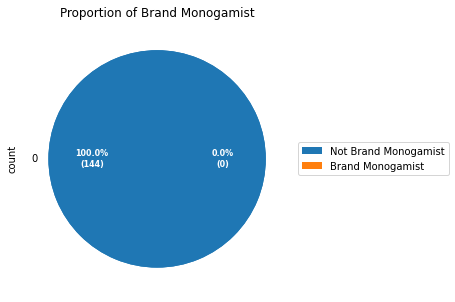

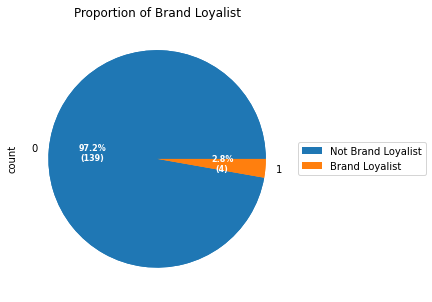

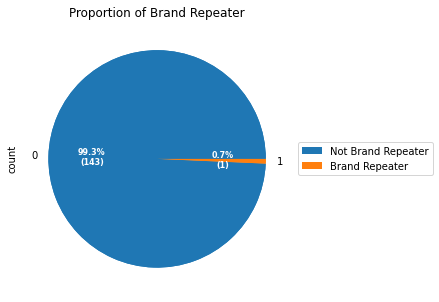

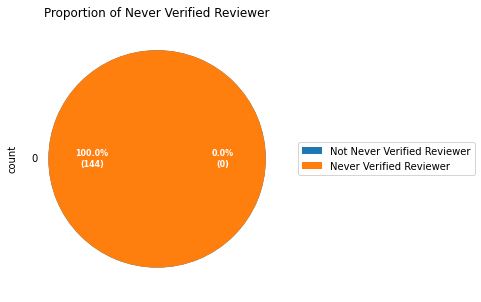

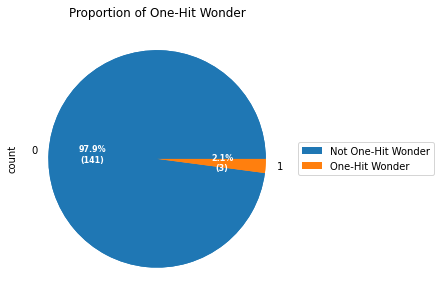

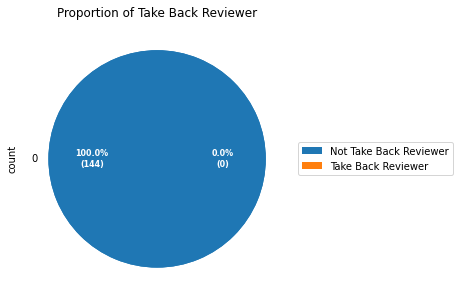

In [61]:
import matplotlib.pyplot as plt
  
fig = plt.figure(figsize =(10, 7)) 

plot_df = interested_user_df[['cleaned_brand_monogamist','cleaned_brand_loyalist','cleaned_brand_repeater','cleaned_never_verified_reviewer','cleaned_one_hit_wonder','cleaned_take_back_reviewer']]

sub_values = {'cleaned_brand_monogamist':'Brand Monogamist','cleaned_brand_loyalist':'Brand Loyalist','cleaned_brand_repeater':'Brand Repeater','cleaned_never_verified_reviewer':'Never Verified Reviewer','cleaned_one_hit_wonder':"One-Hit Wonder",'cleaned_take_back_reviewer':'Take Back Reviewer'}

# # Creating plot 
def func(pct, allvals):
    absolute = int(pct/100.*np.sum(allvals))
    return "{:.1f}%\n({:d})".format(pct, absolute)

for column in plot_df:
    temp_df = plot_df.groupby(column).size().reset_index(name='count')
    column_values = list(temp_df['count'])
    if 0 not in list(temp_df[column]):
        column_values = [0, column_values[0]]
    elif 1 not in list(temp_df[column]):
        column_values = [column_values[0],0]
    index = ["Not " + sub_values[column],sub_values[column]]
    df = pd.DataFrame({index[0]: column_values[0], index[1]:column_values[1]}, index=[0])
    ax = temp_df.plot.pie(y='count',figsize=(5, 5))
    wedges, texts, autotexts = ax.pie(column_values, autopct=lambda pct: func(pct, column_values),
                                  textprops=dict(color="w"))

    ax.legend(wedges, index,
            loc="center left",
            bbox_to_anchor=(1, 0, 0.5, 1))

    plt.setp(autotexts, size=8, weight="bold")

    ax.set_title("Proportion of {}".format(sub_values[column]))
    plt.show() 